In [12]:
import os
import glob
import pandas as pd

import matplotlib.pyplot as plt
import cv2
import numpy as np

from PIL import Image
import numpy as np
from skimage.restoration import denoise_wavelet
from skimage.filters import sobel
from skimage.exposure import equalize_adapthist
import skimage

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.utils
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
# Construct paths to 'real' and 'fake' directories
real_path = '../data/raw/face_real'
fake_path = '../data/raw/face_fake/1m_faces_00'

images_df = {
    "image_path":[],
    "label":[]
}

# Process real images
for subfolder in ['00000', '01000']:
    full_path = os.path.join(real_path, subfolder)
    for file_extension in ["*.jpg", "*.png"]:
        for img in glob.glob(os.path.join(full_path, file_extension)):
            images_df["image_path"].append(img)
            images_df["label"].append('real')
            
# Process fake images, limiting to 2000
count = 0
for file_extension in ["*.jpg", "*.png"]:
    for img in glob.glob(os.path.join(fake_path, file_extension)):
        if count < 2000:  # Limit to 2000 images
            images_df["image_path"].append(img)
            images_df["label"].append('fake')
            count += 1
        else:
            break

# Convert to DataFrame
images_df = pd.DataFrame(images_df)

In [3]:
# View the shape of the DataFrame (rows, columns)
shape = images_df.shape
print(f"Shape of the DataFrame: {shape}")

# Display the first few rows to inspect
print("First few rows of the DataFrame:")
print(images_df.head())

# Get a summary of the DataFrame
print("Summary of the DataFrame:")
print(images_df.info())

Shape of the DataFrame: (4000, 2)
First few rows of the DataFrame:
                              image_path label
0  ../data/raw/face_real/00000/00481.png  real
1  ../data/raw/face_real/00000/00495.png  real
2  ../data/raw/face_real/00000/00324.png  real
3  ../data/raw/face_real/00000/00442.png  real
4  ../data/raw/face_real/00000/00456.png  real
Summary of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  4000 non-null   object
 1   label       4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB
None


# Preprocessing

In [4]:
def resize_image(image: Image.Image, size: tuple[int, int] = (128, 128)) -> Image.Image:
    return image.resize(size)

def normalize_pixels(image_array: np.ndarray) -> np.ndarray:
    return image_array / 255.0

def convert_to_grayscale(image: Image.Image) -> Image.Image:
    return image.convert('L')

def denoise_image(image: np.ndarray) -> np.ndarray:
    # Assuming multichannel is based on the input image shape
    multichannel = image.shape[-1] == 3
    return denoise_wavelet(image, multichannel=multichannel, mode='soft')

def apply_edge_detection(image: np.ndarray) -> np.ndarray:
    return sobel(image)

def equalize_histogram(image: np.ndarray) -> np.ndarray:
    return equalize_adapthist(image, clip_limit=0.03)

def center_crop(image: Image.Image, crop_size: int) -> Image.Image:
    width, height = image.size
    left = (width - crop_size) / 2
    top = (height - crop_size) / 2
    right = (width + crop_size) / 2
    bottom = (height + crop_size) / 2
    return image.crop((left, top, right, bottom))

def standardize_image(image: np.ndarray, mean: float, std: float) -> np.ndarray:
    return (image - mean) / std

def to_numpy_array(image: Image.Image) -> np.ndarray:
    return np.array(image)

In [5]:
def preprocess_pipeline(image_path: str, size: tuple[int, int] = (128, 128), normalize: bool = True, 
                        to_grayscale: bool = False, denoise: bool = False, edge_detection: bool = False, 
                        equalize: bool = False, center_crop_size: int = None, 
                        standardize: bool = False, mean_std: tuple[float, float] = None) -> np.ndarray:
    try:
        with Image.open(image_path) as img:
            img = resize_image(img, size=size)
            
            if to_grayscale:
                img = convert_to_grayscale(img)
            
            img_array = to_numpy_array(img)
            
            if denoise:
                img_array = denoise_image(img_array)
            
            if edge_detection:
                img_array = apply_edge_detection(img_array)
            
            if equalize:
                img_array = equalize_histogram(img_array)
            
            if center_crop_size:
                img = Image.fromarray((img_array * 255).astype(np.uint8))
                img = center_crop(img, center_crop_size)
                img_array = to_numpy_array(img)
            
            if normalize:
                img_array = normalize_pixels(img_array)
            
            if standardize and mean_std:
                mean, std = mean_std
                img_array = standardize_image(img_array, mean, std)
            
            return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [6]:
preprocessed_images = []

for index, row in images_df.iterrows():
    preprocessed_image = preprocess_pipeline(
        image_path=row['image_path'],
        size=(128, 128),
        normalize=True,
        to_grayscale=False,
        denoise=False,  # Adjust according to your requirements
        edge_detection=False,
        equalize=False,
        center_crop_size=None,
        standardize=False
    )
       
    label = 0 if row['label'] == 'real' else 1  # Assign 0 to real, 1 to fake
    preprocessed_images.append((preprocessed_image, label))

    print(f"Processed {os.path.basename(row['image_path'])}")

Processed 00481.png
Processed 00495.png
Processed 00324.png
Processed 00442.png
Processed 00456.png
Processed 00330.png
Processed 00318.png
Processed 00683.png
Processed 00697.png
Processed 00867.png
Processed 00873.png
Processed 00898.png
Processed 00640.png
Processed 00126.png
Processed 00132.png
Processed 00654.png
Processed 00668.png
Processed 00091.png
Processed 00085.png
Processed 00913.png
Processed 00907.png
Processed 00734.png
Processed 00052.png
Processed 00046.png
Processed 00720.png
Processed 00708.png
Processed 00293.png
Processed 00287.png
Processed 00250.png
Processed 00536.png
Processed 00522.png
Processed 00244.png
Processed 00278.png
Processed 00279.png
Processed 00523.png
Processed 00245.png
Processed 00251.png
Processed 00537.png
Processed 00286.png
Processed 00292.png
Processed 00709.png
Processed 00047.png
Processed 00721.png
Processed 00735.png
Processed 00053.png
Processed 00906.png
Processed 00912.png
Processed 00084.png
Processed 00090.png
Processed 00669.png


In [7]:
preprocessed_images_df = pd.DataFrame(preprocessed_images, columns=['image', 'label'])

# Split the Data

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

# Splitting the DataFrame into features and target arrays
X = np.stack(preprocessed_images_df['image'].values)  # Convert column of arrays into single numpy array
y = preprocessed_images_df['label'].values

# First split to separate out the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Second split to separate out the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp, shuffle=True)  # 0.25 x 0.8 = 0.2

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

'''
Training Set: 60% of the original dataset.
Validation Set: 20% of the original dataset.
Testing Set: 20% of the original dataset.
'''

Training set size: 2400
Validation set size: 800
Testing set size: 800


'\nTraining Set: 60% of the original dataset.\nValidation Set: 20% of the original dataset.\nTesting Set: 20% of the original dataset.\n'

In [11]:
X_train.shape

(2400, 128, 128, 3)

# Modelling
- Transfer learning

In [13]:
tf_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freezing the CNN layers
for layer in tf_model.layers:
    layer.trainable = False

model = Sequential([
    tf_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [16]:
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', 
                  patience=10,
                  restore_best_weights=True,verbose=0),
    ReduceLROnPlateau(monitor = 'val_accuracy',patience=2,
                      factor=0.5,
                      min_lr = 0.00001,
                      verbose = 1)
]

In [19]:
mod_hist = model.fit(X_train, y_train, 
                     epochs=10, batch_size=32, 
                     validation_data=(X_val, y_val),
                     callbacks = callbacks_list)

Epoch 1/10


2024-04-07 17:43:26.349157: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


75/75 [==============================] - 256s 3s/step - loss: 0.7797 - accuracy: 0.6154 - val_loss: 0.5881 - val_accuracy: 0.7013 - lr: 0.0010
Epoch 2/10
75/75 [==============================] - 234s 3s/step - loss: 0.5461 - accuracy: 0.7346 - val_loss: 0.5535 - val_accuracy: 0.7175 - lr: 0.0010
Epoch 3/10
75/75 [==============================] - 234s 3s/step - loss: 0.4936 - accuracy: 0.7700 - val_loss: 0.5281 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 4/10
75/75 [==============================] - 238s 3s/step - loss: 0.4547 - accuracy: 0.7950 - val_loss: 0.5285 - val_accuracy: 0.7362 - lr: 0.0010
Epoch 5/10
75/75 [==============================] - 250s 3s/step - loss: 0.4288 - accuracy: 0.8133 - val_loss: 0.5152 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 6/10
75/75 [==============================] - 266s 4s/step - loss: 0.3861 - accuracy: 0.8512 - val_loss: 0.5237 - val_accuracy: 0.7337 - lr: 0.0010
Epoch 7/10
75/75 [==============================] - ETA: 0s - loss: 0.3589 - accuracy: 

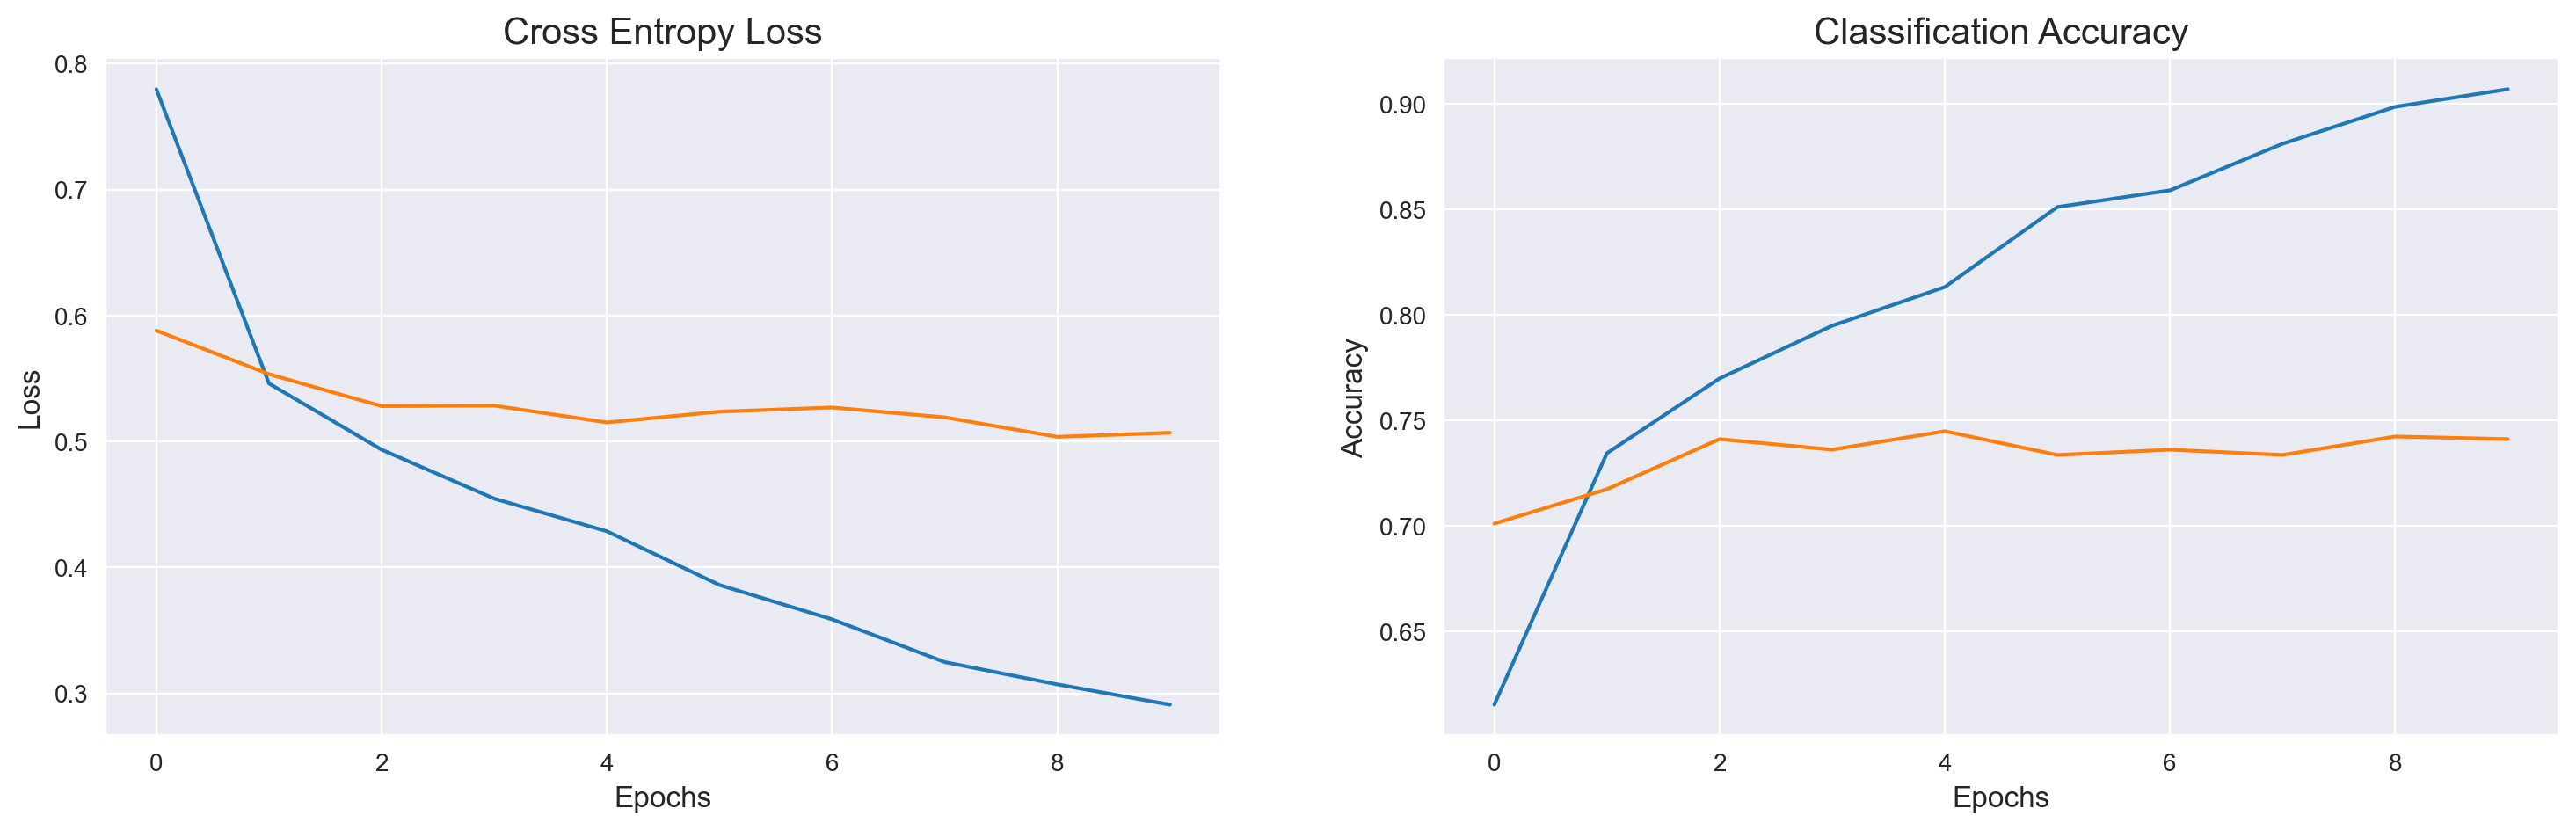

In [20]:
# plots for accuracy and Loss with epochs
error = pd.DataFrame(mod_hist.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [21]:
loss, accuracy = model.evaluate(X_test, y_test)
print(accuracy)

25/25 [==============================] - 59s 2s/step - loss: 0.5120 - accuracy: 0.7700
0.7699999809265137


In [ ]:
model.save("tf_model.h5")

In [ ]:
#Classes: fake == 1, real==0 
y_probab = tf_model.predict(X_test) # probability of class = 1
scam_probab = y_probab.squeeze()  # squeeze from single dimension
print(y_probab)